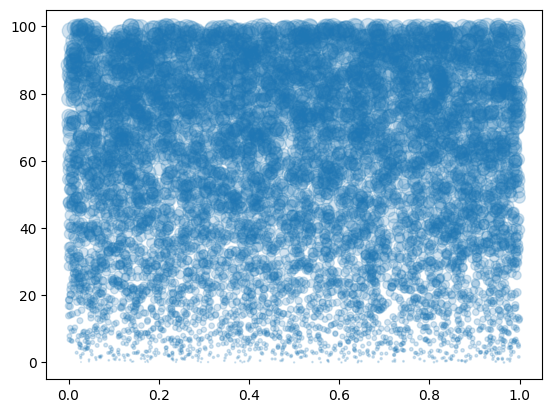

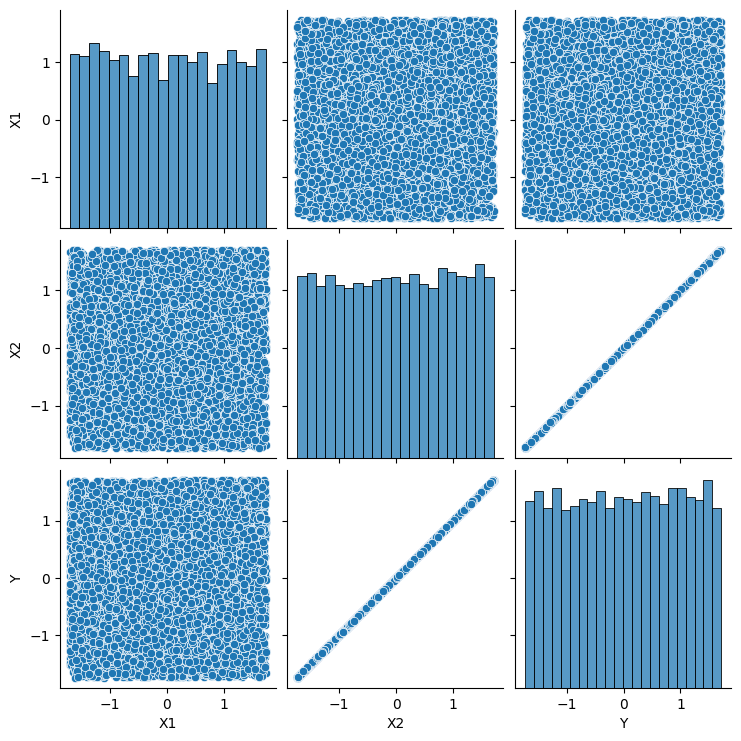

In [23]:
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Binarizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score, median_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

def generate_data():
    x1 = [random.random() for _ in range(10000)]
    x2 = [100*random.random() for _ in range(10000)]
    y = [x+1.4*y for x,y in zip(x1,x2)]
    pd.DataFrame({'X1':x1, 'X2':x2, 'Y':y}).to_csv('data.csv')

def read_csv(path):
    df = pd.read_csv(path).drop(columns=['Unnamed: 0'], axis=1)
    return df

def arbritary_null(df):
    for row in df.iterrows():
        change_x1 = random.random() < 0.2
        change_x2 = random.random() < 0.1
        change_y = random.random() < 0.05
        index = row[0]
        if change_x1:
            df.loc[index,'X1'] = np.nan
        if change_x2:
            df.loc[index,'X2'] = np.nan
        if change_y:
            df.loc[index,'Y'] = np.nan
    return df

def filter_y_not_na(df):
    return df[~ df['Y'].isna()] 

def standard_scale(df):
    scaler = StandardScaler()
    df[['X1','X2']] = scaler.fit_transform(df[['X1','X2']])
    return df
def impute_missing_values(df):
    imputer = SimpleImputer(missing_values=np.nan,strategy='mean')
    df['X1'] = imputer.fit_transform(df[['X1']])
    df['X2'] = imputer.fit_transform(df[['X2']])
    return df

def show_pairplot(df):
    scaler = StandardScaler()
    scaled_df = df.copy()
    scaled_df[scaled_df.columns] = scaler.fit_transform(scaled_df[scaled_df.columns])
    pp = sns.pairplot(scaled_df)
    plt.show(pp)

path='data.csv'
df = read_csv(path)
df = arbritary_null(df)
df = filter_y_not_na(df)

plt.scatter(df['X1'],df['X2'],df['Y'], alpha=0.2)

show_pairplot(df)

X = df.drop(columns=['Y'])
y = df['Y']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3, random_state=224)


impute_and_scale = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', impute_and_scale, ['X1','X2'])
    ]
)
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'SVR': SVR()
}

param_grids = {
    'Linear Regression': {
        'regressor__fit_intercept': [True, False],
    },
    'Decision Tree' : {
        'regressor__max_depth': [None, 10,20,30],
        'regressor__min_samples_split': [2, 5, 10],
    },
    'Random Forest' : {
        'regressor__n_estimators': [50, 100, 200],
        'regressor__max_depth': [None, 10, 20],
        'regressor__min_samples_split': [2, 5, 10],
        'regressor__bootstrap': [True,False],
    },
    'SVR' : {
        'regressor__C': [0.1, 1, 10],
        'regressor__epsilon': [0.01, 0.1, 0.2],
    },
}

def train_():
    result=[]
    for model_name, model in models.items():
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', model),
        ])

        grid_search = GridSearchCV(
            pipeline,
            param_grid=param_grids[model_name],
            n_jobs=-1,
            verbose=1,
        )

        grid_search.fit(X_train, y_train)

        
        best_model = grid_search.best_estimator_    

        y_pred=best_model.predict(X_test)

        # metrices = (mean_absolute_error, mean_squared_error, r2_score, explained_variance_score, median_absolute_error)
        metrics = {
            'mean_absolute_error' : mean_absolute_error,
            'mean_squared_error' : mean_squared_error,
            'r2_score' : r2_score,
            'explained_variance_score' : explained_variance_score,
            'median_absolute_error' : median_absolute_error,
        }
        metrics_eval_score = dict( {metric_name: metric(y_test, y_pred) for metric_name,metric in metrics.items()})
        metrics_eval_score.update({'model': model_name})
        result.append(metrics_eval_score)
    result_df = pd.DataFrame(result)
    result_df = result_df.reindex(['model',*list(set(list(result_df.columns)).difference(['model']))], axis=1)

    result_df

import plotly.express as px
fig = px.scatter_matrix(df, dimensions=df.columns)
fig.show()
corr = df.corr()
fig = px.imshow(
    corr, 
    title='Feature Correlation Matrix',
    labels=dict(X1='x1', X2='x2', Y='y'),
    text_auto='.2f',
    color_continuous_scale="RdBu"
)
fig.show()